In [4]:
## 基础工具
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## 数据降维处理工具
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

## 参数搜索和评价指标
#from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split as TTS, cross_val_score as CVS, StratifiedKFold,GridSearchCV
#from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

import xgboost as xgb
#import lightgbm as lgb


## **数据读取**
同时读入训练集和测试集的原因是：
- 若测试集有缺失值等，用训练集来填补；
- 查看训练集和测试集的分布，若数据分布情况不一致/相近，需要对训练集进行负采样等处理，使训练集的分布与测试集相似

In [5]:
train_data = pd.read_csv('./used_car_train_20200313.csv', sep=' ', index_col=0)
test_data = pd.read_csv('./used_car_testA_20200313.csv', sep=' ', index_col=0)

## **EDA Exploratory Data Analysis**
### 查看数据整体情况

In [7]:
train_data.head(),train_data.tail()  # 查看头尾5行
train_data.shape  # 数据规模
train_data.columns  # 查看特征名字，对感兴趣/觉得重要的特征可以留意探查
#train_data.info()  # 查看各列数据类型，看一下有无缺失值
train_data.describe()  #看一下各列的描述性统计结果，看一下有无异常值（max/min离mean/75%差很多个std就可能为异常值）

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,2583.077267,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,1885.363218,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,1018.000000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,2196.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,3843.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,8120.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [14]:
# test_data.info()
# test_data.describe
# test_data.tail()

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
SaleID,,,,,,,,,,,,,,,,,,,,,
199995,20903,19960503,4.0,4,4.0,0.0,0.0,116,15.0,0.0,...,0.284664,0.130044,0.049833,0.028807,0.004616,-5.978511,1.303174,-1.207191,-1.981240,-0.357695
199996,708,19991011,0.0,0,0.0,0.0,0.0,75,15.0,0.0,...,0.268101,0.108095,0.066039,0.025468,0.025971,-3.913825,1.759524,-2.075658,-1.154847,0.169073
199997,6693,20040412,49.0,1,0.0,1.0,1.0,224,15.0,0.0,...,0.269432,0.105724,0.117652,0.057479,0.015669,-4.639065,0.654713,1.137756,-1.390531,0.254420
199998,96900,20020008,27.0,1,0.0,0.0,1.0,334,15.0,0.0,...,0.261152,0.000490,0.137366,0.086216,0.051383,1.833504,-2.828687,2.465630,-0.911682,-2.057353
199999,193384,20041109,166.0,6,1.0,NaN,1.0,68,9.0,0.0,...,0.228730,0.000300,0.103534,0.080625,0.124264,2.914571,-1.135270,0.547628,2.094057,-1.552150


### 查看目标变量y的类型

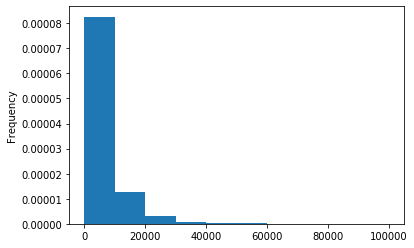

In [8]:
# price为目标变量，希望学习一个给定其它指标能够预测二手车价格的模型
train_data.price.unique()  # 查看类别
#train_data.price.value_counts()  #分类变量各类的数量
train_data.price.plot(kind='hist',density=True)  # 类别变量画直方图
plt.show()

### 查看个变量/特征的情况
总体已经在info和describe中看过了，可以针对个别感兴趣/觉得重要的特征，对单个变量画图查看分布情况等。

用来确定建模类型： 连续变量用回归，离散变量用分类，无目标变量用聚类

In [9]:
train_data.columns

Index(['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller',
       'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

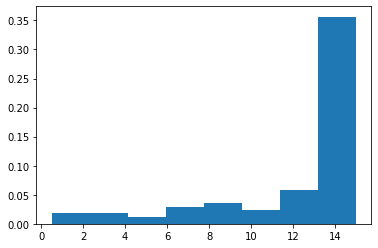

In [10]:
plt.hist(train_data['kilometer'], bins=8, density=True)
plt.show()

### 初步进行探索性特征工程
截取dataFrame相关系数矩阵中目标变量y的那一列，排序后可见相关程度

In [11]:
train_data.corr()['price'].sort_values(ascending=False)

price         1.000000
v_12          0.692823
v_8           0.685798
v_0           0.628397
regDate       0.611959
gearbox       0.329075
bodyType      0.241303
power         0.219834
fuelType      0.200536
v_5           0.164317
model         0.136983
v_2           0.085322
v_6           0.068970
v_1           0.060914
v_14          0.035911
regionCode    0.014036
creatDate     0.002955
name          0.002030
seller       -0.002004
v_13         -0.013993
brand        -0.043799
v_7          -0.053024
v_4          -0.147085
v_9          -0.206205
v_10         -0.246175
v_11         -0.275320
kilometer    -0.440519
v_3          -0.730946
offerType          NaN
Name: price, dtype: float64

## **数据清洗**
### 数据合并

In [21]:
# # union增加行， axis=1为增加列#
# pd.concat([data1,data2], ignore_index=True)

# # join 增加列
# pd.merge(data1, data2, left_on='col1', right_on='left') # 默认how='inner'

# # also join 方法
# data1.join(join2, how='inner')  # 默认how='left'

### 缺失值处理

In [12]:
# 查看缺失值
train_data.isnull().any()  # 返回列名和True/False
train_data.isnull().sum()  # 返回列名和缺失值数量

name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

In [13]:
test_data.isnull().sum()

name                    0
regDate                 0
model                   0
brand                   0
bodyType             1413
fuelType             2893
gearbox              1910
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

*对于以下算法，本身允许缺失值直接进入分析挖掘，将na视作一个特定的属性类别。此时不需要处理缺失值：*
- 决策树、RF、NN、NaiveBayes、KNN、DBSCAN等算法都容许缺失值的存在
- 因此采用树模型可以更好地利用数据（尤其当缺失值占比较高时）

*若不打算采取上述算法，先对缺失值的含义进行判断，看其有无意义：如*
- 信用卡激活时间的缺失大概率意味着用户未激活——不删
- 字段除数为0表示计算逻辑有误，需要修改——不删

*确定需要处理，主要有三种处理方法：直接删除、统计插值、建模插值*
- NA占比小，且na分布无规律性，且后序应用数据完整度高————直接删除

优点：处理后数据干净，操作简便；
缺点：消除数据特征，损失有效信息

In [14]:
# model行缺失1个值，删除
train_data = train_data.dropna(how='any', subset=['model'])  #一行为单位，how=‘all’删除所有na的行;axis=1为删除列
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 30 columns):
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             145493 non-null float64
fuelType             141319 non-null float64
gearbox              144018 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    149999 non-null object
regionCode           149999 non-null int64
seller               149999 non-null int64
offerType            149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4                  149999 non-null float64
v_5     

- 对空值进行描述性统计值补全/人为插值：SimpleImputer

数值型特征变量：均值、中位数、常数

分类型特征：众数、常数

In [15]:
from sklearn.impute import SimpleImputer
# # numeric value: mean\median #
# imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='0')
# dataset['missed'] = imp.fit_transform(dataset['missed'])

# categorical value: mode constant #
# baseline中先用众数来填补bodyType fuelType gearbox of train set and test set
imp1 = SimpleImputer(strategy='most_frequent')
imp1.fit(np.array(train_data['bodyType']).reshape(-1,1))
train_data['bodyType'] = imp1.transform(np.array(train_data['bodyType']).reshape(-1,1))
test_data['bodyType'] = imp1.transform(np.array(test_data['bodyType']).reshape(-1,1))

imp2 = SimpleImputer(strategy='most_frequent')
imp2.fit(np.array(train_data['fuelType']).reshape(-1,1))
train_data['fuelType'] = imp2.transform(np.array(train_data['fuelType']).reshape(-1,1))
test_data['fuelType'] = imp2.transform(np.array(test_data['fuelType']).reshape(-1,1))

imp3 = SimpleImputer(strategy='most_frequent')
imp3.fit(np.array(train_data['gearbox']).reshape(-1,1))
train_data['gearbox'] = imp3.transform(np.array(train_data['gearbox']).reshape(-1,1))
test_data['gearbox'] = imp3.transform(np.array(test_data['gearbox']).reshape(-1,1))



In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 150000 to 199999
Data columns (total 29 columns):
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             50000 non-null float64
fuelType             50000 non-null float64
gearbox              50000 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non-null float64
v_6                  5

In [17]:
imp4 = SimpleImputer(missing_values='-', strategy='most_frequent')
imp4.fit(np.array(train_data['notRepairedDamage']).reshape(-1,1))
train_data['notRepairedDamage'] = imp4.transform(np.array(train_data['notRepairedDamage']).reshape(-1,1))
test_data['notRepairedDamage'] = imp4.transform(np.array(test_data['notRepairedDamage']).reshape(-1,1))

In [18]:
np.unique(train_data.notRepairedDamage)

array(['0.0', '1.0'], dtype=object)

In [19]:
train_data.notRepairedDamage = train_data.notRepairedDamage.astype('float')
test_data.notRepairedDamage = test_data.notRepairedDamage.astype('float')

In [20]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 30 columns):
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             149999 non-null float64
fuelType             149999 non-null float64
gearbox              149999 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    149999 non-null float64
regionCode           149999 non-null int64
seller               149999 non-null int64
offerType            149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4                  149999 non-null float64
v_5    

## 建模处理
此处baseline仅对特征进行了初步的处理

In [21]:
# 划分特征和标签
y = train_data.iloc[:, train_data.columns=='price']
X = train_data.iloc[:, train_data.columns!='price']


In [22]:
dfull = xgb.DMatrix(X,y)

In [ ]:
# 先采用网格搜索 找到最佳num_round 和eta的组合
# 默认参数baseline

06:41:486817
01:05:445683
01:05:361057


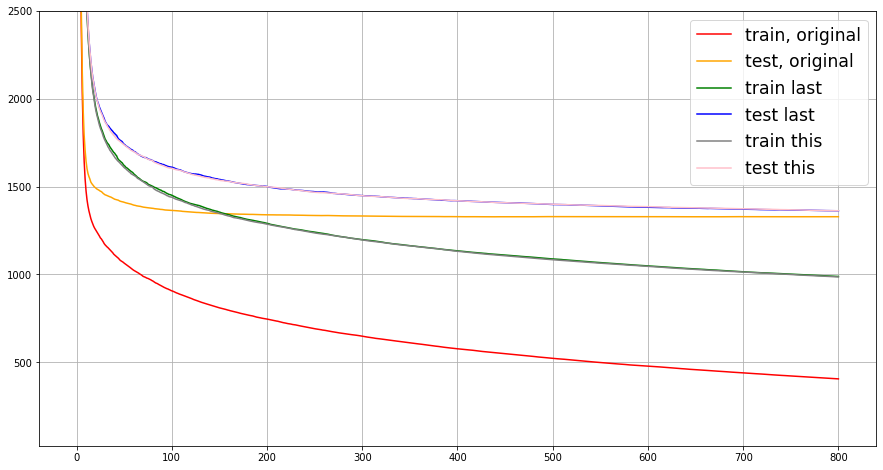

In [44]:
# xgb.cv 调参
import datetime
from time import time
param1 = {'silent': True # 非默认
         , 'obj': 'reg:linear'  # 非默认
         , 'metric': 'mae'
         , 'subsample':1
         , 'max_depth':6
         , 'eta':0.3
         , 'gamma':0
         , 'lambda':1
         , 'alpha':0
         , 'colsample_bytree':1
         , 'colsample_bylevel':1
         , 'colsample_bynode':1}
num_round = 800
n_fold = 5

time0 = time()
cvResult1 = xgb.cv(param1, dfull, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
fig, ax = plt.subplots(1,figsize=(15,8))
ax.grid()
ax.plot(range(1,num_round+1), cvResult1.iloc[:,0], c='r', label='train, original')
ax.plot(range(1,num_round+1), cvResult1.iloc[:,2], c='orange', label='test, original')


param2 = {'silent':True, 'obj':'reg:linear','metric':'mae'
          , 'max_depth':3
          , 'gamma':5
          , 'eta': 0.2
          , 'colsample_bytree':0.6
          , 'colsample_bylevel':0.8
          , 'alpha':0
          , 'lambda':1}


param3 = {'silent':True, 'obj':'reg:linear','metric':'mae'
          , 'max_depth':3
          , 'gamma':5
          , 'eta': 0.2
          , 'colsample_bytree':0.6
          , 'colsample_bylevel':0.8
          , 'aplha':0
          , 'lambda':0.5}

time0 = time()
cvResult2 = xgb.cv(param2, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

time0 = time()
cvResult3 = xgb.cv(param3, dfull, num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

ax.plot(range(1,num_round+1), cvResult2.iloc[:,0], c='green', label='train last')
ax.plot(range(1,num_round+1), cvResult2.iloc[:,2], c='blue', label='test last')


ax.plot(range(1,num_round+1), cvResult3.iloc[:,0], c='grey', label='train this')
ax.plot(range(1,num_round+1), cvResult3.iloc[:,2], c='pink', label='test this')
ax.legend(fontsize='xx-large')
ax.set_ylim(top=2500)
plt.show()